In [1]:
import torch
import torch.nn as nn
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torchsummary import summary
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

train_set = datasets.MNIST(
    download=True,
    root='Data',
    train=True,
    transform=ToTensor(),
)

test_set = datasets.MNIST(
    download=True,
    root='Data',
    train=False,
    transform=ToTensor(),
)


In [36]:
train_loader = DataLoader(train_set, batch_size=30, shuffle=True)
test_loader = DataLoader(test_set, batch_size=50, shuffle=False)

In [43]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.pool1 = nn.MaxPool2d(2, stride=2)
        self.dropout1 = nn.Dropout(0.25)
        
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.pool2 = nn.MaxPool2d(2, stride=2)
        self.dropout2 = nn.Dropout(0.50)
        
        self.layer = nn.Linear(1024, 10)
    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.dropout1(x)
        
        x = nn.functional.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.dropout2(x)
        
        x = x.reshape(-1, 1024)
        x = nn.functional.relu(self.layer(x))
        return x

In [32]:
# Do not change this cell
def caluculate_acc(data, model, length):
  model.eval()
  acc = 0
  for images, label in data:
    with torch.no_grad():
      images = images.to(device)
      label = label.to(device)
      yp = model(images)
      yp = torch.nn.functional.softmax(yp, dim=1)
      yp = torch.argmax(yp, 1)
      acc += torch.sum(yp == label)
  return acc / length

In [33]:
# Do not change this cell
def train_one_epoch(model, data, optimizer, criterion, length):
  model.train()
  acc = 0
  for images, labels in data:
    imgs = torch.autograd.Variable(images).to(device)
    label = torch.autograd.Variable(labels).to(device)
    optimizer.zero_grad()
    yp = model(imgs)
    loss = criterion(yp, label)
    loss.backward()
    optimizer.step()
    yp = torch.argmax(yp, 1)
    acc += torch.sum(yp == label)
  return loss.item(), acc / length

In [44]:
model = Model().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()

# model summary
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]             832
         MaxPool2d-2           [-1, 32, 12, 12]               0
           Dropout-3           [-1, 32, 12, 12]               0
            Conv2d-4             [-1, 64, 8, 8]          51,264
         MaxPool2d-5             [-1, 64, 4, 4]               0
           Dropout-6             [-1, 64, 4, 4]               0
            Linear-7                   [-1, 10]          10,250
Total params: 62,346
Trainable params: 62,346
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.26
Params size (MB): 0.24
Estimated Total Size (MB): 0.50
----------------------------------------------------------------


In [45]:
# training process
val_accs = []
accs = []
best_acc = 0
for e in tqdm(range(20)):
  accs.append(train_one_epoch(model, train_loader, optimizer, criterion, len(train_set))[1].item())
  val_accs.append(caluculate_acc(test_loader, model, len(test_set)).item())
  print(f"epoch {e}: accuracy:{accs[-1]} val_accuracy:{val_accs[-1]}")
  if best_acc < val_accs[-1]:
    torch.save(model, "cnnModel.h5")
    best_Acc = val_accs[-1]
  
  # just a way to avoid overfitting
  if val_accs[-1] > 0.99 and accs[-1] > 0.99:
    break

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 0: accuracy:0.7767000198364258 test_accuracy:0.864300012588501
epoch 1: accuracy:0.8583833575248718 test_accuracy:0.8712000250816345
epoch 2: accuracy:0.866599977016449 test_accuracy:0.9811000227928162
epoch 3: accuracy:0.9779166579246521 test_accuracy:0.9883000254631042
epoch 4: accuracy:0.9815000295639038 test_accuracy:0.9904000163078308
epoch 5: accuracy:0.9839166402816772 test_accuracy:0.991599977016449
epoch 6: accuracy:0.984416663646698 test_accuracy:0.9908000230789185
epoch 7: accuracy:0.9860000014305115 test_accuracy:0.9927999973297119
epoch 8: accuracy:0.9861999750137329 test_accuracy:0.9927999973297119
epoch 9: accuracy:0.9877166748046875 test_accuracy:0.9926999807357788
epoch 10: accuracy:0.9882000088691711 test_accuracy:0.9927999973297119
epoch 11: accuracy:0.9885666370391846 test_accuracy:0.9925000071525574
epoch 12: accuracy:0.9884666800498962 test_accuracy:0.9929999709129333
epoch 13: accuracy:0.9893500208854675 test_accuracy:0.9932000041007996
epoch 14: accuracy:0

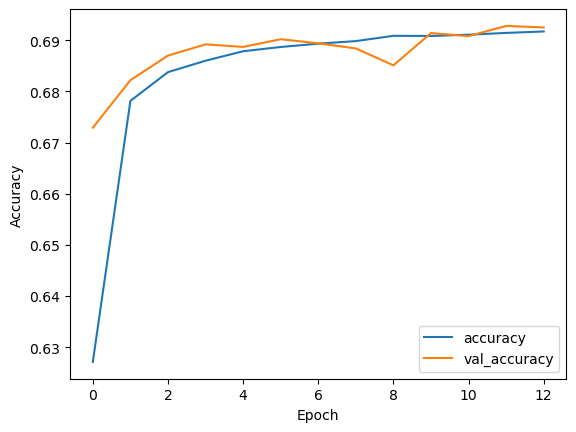

In [17]:
plt.plot(accs, label='accuracy')
plt.plot(val_accs, label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show();

In [ ]:
caluculate_acc(test_loader, model, len(test_set)).item(), caluculate_acc(train_loader, model, len(train_set)).item()